In [50]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lasair
from datetime import datetime
from utils import *
import warnings
import sncosmo
from astropy.table import Table

project_root = Path("/Users/david/Code/msc/project")
data_path = project_root / "data"
src_path = project_root / "src"
print(f"Looking for src at: {src_path}")
print(f"Does src directory exist: {src_path.exists()}")
sys.path.append(str(src_path))
print(f"Added to sys.path: {src_path}")
print(f"Current working directory: {Path.cwd()}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for src at: /Users/david/Code/msc/project/src
Does src directory exist: True
Added to sys.path: /Users/david/Code/msc/project/src
Current working directory: /Users/david/Code/msc/project/src


In [51]:
ZTF_CSV_PATH = data_path / "ztf.csv"
df = pd.read_csv(ZTF_CSV_PATH)
print(f"Loaded {len(df)} objects from ztf.csv")
df.head()

# ZTF ID:	ZTF 9-letter identifier.
# TNS ID:	TNS AT/SN code. (A few transients are wrongly matched on TNS.)
# Disc ID:	Discovery name posted by the first team to register the transient on TNS.
# RA:	Right ascension.
# Dec:	Declination.
# time:	Time of peak, expressed as JD-2458000.
# mag:	Peak P48 measured magnitude. (If the true peak was missed, this is an upper limit.)
# M_abs:	Absolute magnitude at measured peak, given the observed redshift and extinction. Applies a basic k-correction.
# Rise:	Rise time from half-peak to peak. (This is calculated crudely by linearly interpolating the light curve, including upper limits before the first detection). If no detections or limits deeper than 0.75 mag below peak exist in the post-peak alert history this is given as a limit.
# Fade:	Fade time from peak to half-peak. (Calculated the same way as rise time.) If no detections deeper than 0.75 mag below peak exist in the post-peak alert history this is given as a limit.
# Duration:	The sum of rise and fade times, i.e. the time above half-maximum.
# Type:	Classification from TNS.
# Redshift:	Redshift. Often approximate. (For M31/M33 this is D_L*H_0*c.)
# Host M_i:	Host absolute magnitude. Incudes a basic color-dependent k-correction. Not reliable for PS1 or nearby galaxies (see above); omitted at z<0.01.
# Host g-i:	Host rest-frame g-i color. Not reliable for PS1 or nearby galaxies (see above).
# Cuts:	Bit codes indicating which cut criteria the transient passes.
# b:	Galactic latitude in degrees.
# A_V:	Galactic extinction in V-band in mag.

Loaded 29 objects from ztf.csv


,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
0,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053
1,ZTF17aabvong,SN2024xxq,02:05:07.68,+11:14:55.1,2606.75,g,16.8039,-19.57,23.222,8.464,14.758,SN Ia,0.03400,-47.664064,0.446
2,ZTF17aacldgo,SN2022zxv,03:09:24.36,-04:53:39.2,1897.75,g,18.7979,-18.91,>1077,>3.85,>1073.15,SN Ia,0.07200,-50.332472,0.183
3,ZTF17aadlxmv,SN2020adv,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.06200,34.174702,0.106
4,ZTF18aaaonon,SN2022jjs,10:19:05.51,+14:24:16.6,1703.77,g,18.5663,-19.08,>18.631,3.691,>14.94,SN Ia,0.07141,52.363911,0.150


In [52]:
# User input prompts
def get_user_input():
    """Get run name, ID (or 'all' for all rows), and force flag from user input."""
    run_name = input("Run name (data/<run_name>/, runs/<run_name>/): ").strip()
    ztf_id = input("Enter ZTF ID (e.g., ZTF17aabtvsy) or 'all' for all rows: ").strip()
    force = input("Force run? (y/n, default: n): ").strip().lower() == 'y'
    return run_name, ztf_id, force

# Get user inputs
run_name, ztf_id, force_run = get_user_input()
run_name = run_name.strip() or datetime.now().strftime('%Y-%m-%d')
process_all = ztf_id.lower() in ['all', 'a', '']

if process_all:
    print(f"\nRun: {run_name}")
    print(f"Processing ALL {len(df)} objects from ztf.csv")
    print(f"Force run: {force_run}")
    # Create a copy to ensure original df is never modified
    objects_to_process = df.copy()
else:
    print(f"\nRun: {run_name}")
    print(f"Processing ZTF ID: {ztf_id}")
    print(f"Force run: {force_run}")
    objects_to_process = df[df['ZTFID'] == ztf_id].copy()
    
    if objects_to_process.empty:
        print(f"Warning: No data found for ZTF ID {ztf_id}")
        print(f"Available IDs (first 10): {df['ZTFID'].head(10).tolist()}")
    else:
        print(f"\nFound {len(objects_to_process)} entry(ies) for {ztf_id}")
        print(objects_to_process[['ZTFID', 'IAUID', 'type', 'peakmag', 'peakt']].to_string())

Run name (data/<run_name>/, runs/<run_name>/): test_2
Enter ZTF ID (e.g., ZTF17aabtvsy) or 'all' for all rows: all
Force run? (y/n, default: n): 

Run: test_2
Processing ALL 29 objects from ztf.csv
Force run: False


In [53]:
# Download data for objects
if not objects_to_process.empty:
    total = len(objects_to_process)
    for idx, (_, obj_row) in enumerate(objects_to_process.iterrows(), 1):
        ztf_id = obj_row['ZTFID']
        tns_id = obj_row['IAUID']
        # Remove "SN" prefix from TNS ID if present
        if tns_id.startswith('SN'):
            tns_id = tns_id[2:]
        
        lasair_csv_path = None
        lasair_status = None
        tns_ascii_path = None
        tns_status = None
        if not force_run:
            row = get_tracker_row(ztf_id, project_root, run_name)
            if row and row['lasair_path'] and row['tns_path']:
                print(f"[{idx}/{total}] {ztf_id}: already downloaded")
                continue
            
        try:
            # Download Lasair CSV data
            try:
                lasair_csv_path = download_lasair_csv(ztf_id, project_root=project_root, run_name=run_name)
                lasair_status = "downloaded"
            except Exception as lasair_error:
                lasair_csv_path = None
                lasair_status = f"failed: {str(lasair_error)}"

            # Download TNS ASCII
            # try:
            #     tns_ascii_path = download_tns_ascii(tns_id, project_root=project_root, run_name=run_name)
            #     tns_status = "downloaded"
            # except Exception as tns_error:
            #     tns_ascii_path = None
            #     tns_status = f"failed: {str(tns_error)}"
            
            # Update tracker with both statuses
            # update_tracker(
            #     ztf_id,
            #     lasair_status=lasair_status,
            #     lasair_path=Path(lasair_csv_path) if lasair_csv_path else None,
            #     tns_status=tns_status,
            #     tns_path=Path(tns_ascii_path) if tns_ascii_path else None,
            #     project_root=project_root,
            #     run_name=run_name,
            # )
            
            print(f"[{idx}/{total}] {ztf_id}: Lasair:{lasair_status} TNS:{tns_status}")
        except Exception as e:
            print(f"[{idx}/{total}] {ztf_id}: Failed - {str(e)}")
            # Update tracker with failure status
            update_tracker(
                ztf_id,
                lasair_status=lasair_status or f"failed: {str(e)}",
                lasair_path=None,
                tns_status=tns_status or f"failed: {str(e)}",
                tns_path=None,
                project_root=project_root,
                run_name=run_name,
            )
    
    print(f"\nDownloads complete for {total} object(s)")
    # Remove objects whose Lasair CSV has empty unforced_mag_error
    n_before = len(objects_to_process)
    objects_to_process = filter_objects_by_lasair_mag_error(objects_to_process, project_root, run_name)
    n_removed = n_before - len(objects_to_process)
    if n_removed:
        print(f"Removed {n_removed} object(s) with empty unforced_mag_error in Lasair data. {len(objects_to_process)} object(s) remaining.")
else:
    print("\nCannot proceed without valid ZTF ID")

[1/29] ZTF17aabtvsy: Lasair:downloaded TNS:None
[2/29] ZTF17aabvong: Lasair:downloaded TNS:None
[3/29] ZTF17aacldgo: Lasair:downloaded TNS:None
[4/29] ZTF17aadlxmv: Lasair:downloaded TNS:None
[5/29] ZTF18aaaonon: Lasair:downloaded TNS:None
[6/29] ZTF18aaaooqj: Lasair:downloaded TNS:None
[7/29] ZTF18aaaqexr: Lasair:downloaded TNS:None
[8/29] ZTF18aadlaxo: Lasair:downloaded TNS:None
[9/29] ZTF18aadxnul: Lasair:downloaded TNS:None
[10/29] ZTF18aadzfso: Lasair:downloaded TNS:None
[11/29] ZTF18aaeqjmc: Lasair:downloaded TNS:None
[12/29] ZTF18aaermez: Lasair:downloaded TNS:None
[13/29] ZTF18aafdigb: Lasair:downloaded TNS:None
[14/29] ZTF18aafzers: Lasair:downloaded TNS:None
[15/29] ZTF18aagkwgz: Lasair:downloaded TNS:None
[16/29] ZTF18aagtwyh: Lasair:downloaded TNS:None
[17/29] ZTF18aahatvc: Lasair:downloaded TNS:None
[18/29] ZTF18aahfbqp: Lasair:downloaded TNS:None
[19/29] ZTF18aahtjsc: Lasair:downloaded TNS:None
[20/29] ZTF18aahvndq: Lasair:downloaded TNS:None
[21/29] ZTF18aailmnv: Lasair:

[1/16] ZTF17aabtvsy: Light curve → /Users/david/Code/msc/project/runs/test_1/ZTF17aabtvsy/figures/2026-01-30_ZTF17aabtvsy_light_curve.png
[1/16] ZTF17aabtvsy: Spectrum → /Users/david/Code/msc/project/runs/test_1/ZTF17aabtvsy/figures/2026-01-30_ZTF17aabtvsy_spectrum.png
[2/16] ZTF17aabvong: Light curve → /Users/david/Code/msc/project/runs/test_1/ZTF17aabvong/figures/2026-01-30_ZTF17aabvong_light_curve.png
[2/16] ZTF17aabvong: Spectrum → /Users/david/Code/msc/project/runs/test_1/ZTF17aabvong/figures/2026-01-30_ZTF17aabvong_spectrum.png
[3/16] ZTF17aacldgo: Light curve → /Users/david/Code/msc/project/runs/test_1/ZTF17aacldgo/figures/2026-01-30_ZTF17aacldgo_light_curve.png
[3/16] ZTF17aacldgo: Spectrum → /Users/david/Code/msc/project/runs/test_1/ZTF17aacldgo/figures/2026-01-30_ZTF17aacldgo_spectrum.png
[4/16] ZTF17aadlxmv: Light curve → /Users/david/Code/msc/project/runs/test_1/ZTF17aadlxmv/figures/2026-01-30_ZTF17aadlxmv_light_curve.png
[4/16] ZTF17aadlxmv: Spectrum → /Users/david/Code/ms

/Users/david/Code/msc/project/src/utils.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  


[16/16] ZTF18aaeqjmc: Light curve → /Users/david/Code/msc/project/runs/test_1/ZTF18aaeqjmc/figures/2026-01-30_ZTF18aaeqjmc_light_curve.png

Plotting complete for 16 object(s)


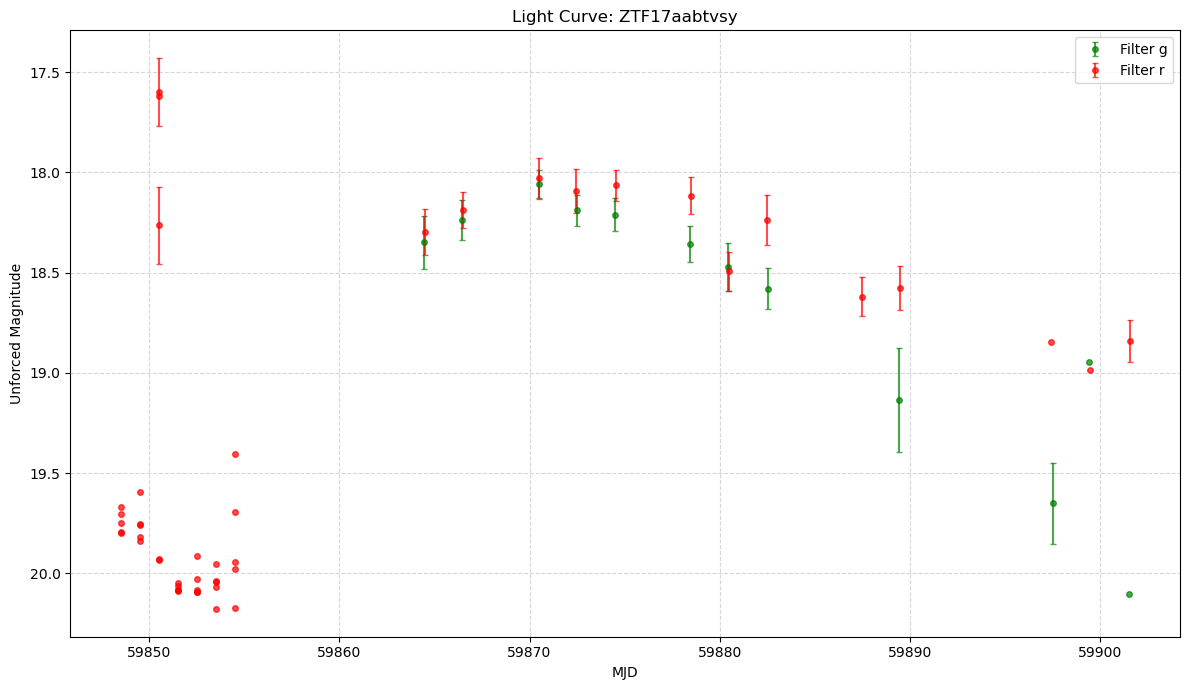

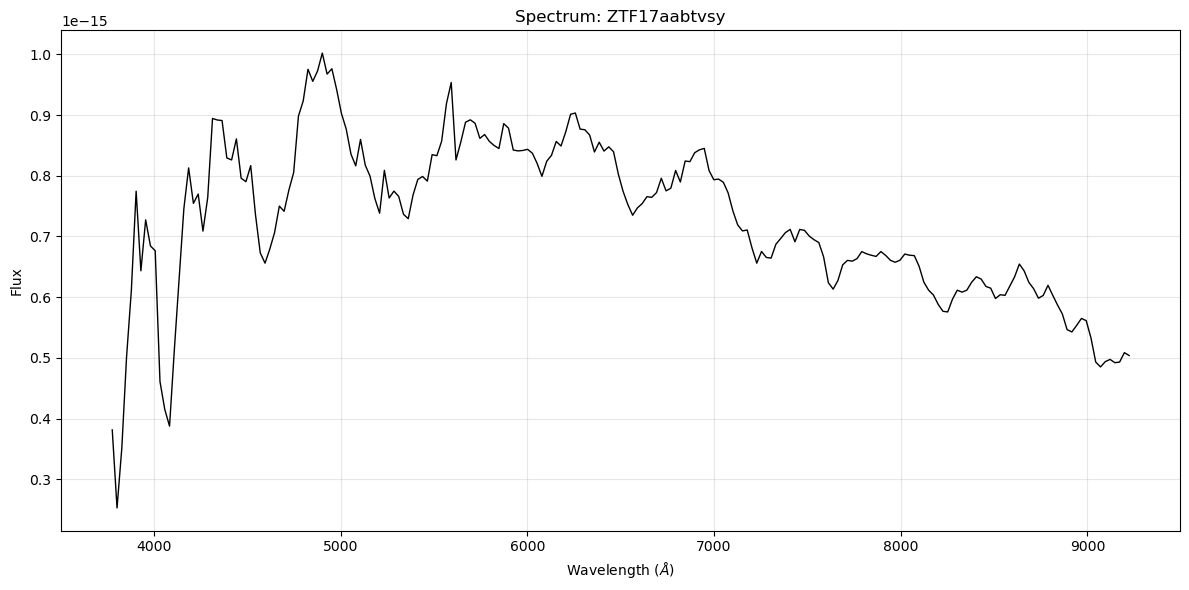

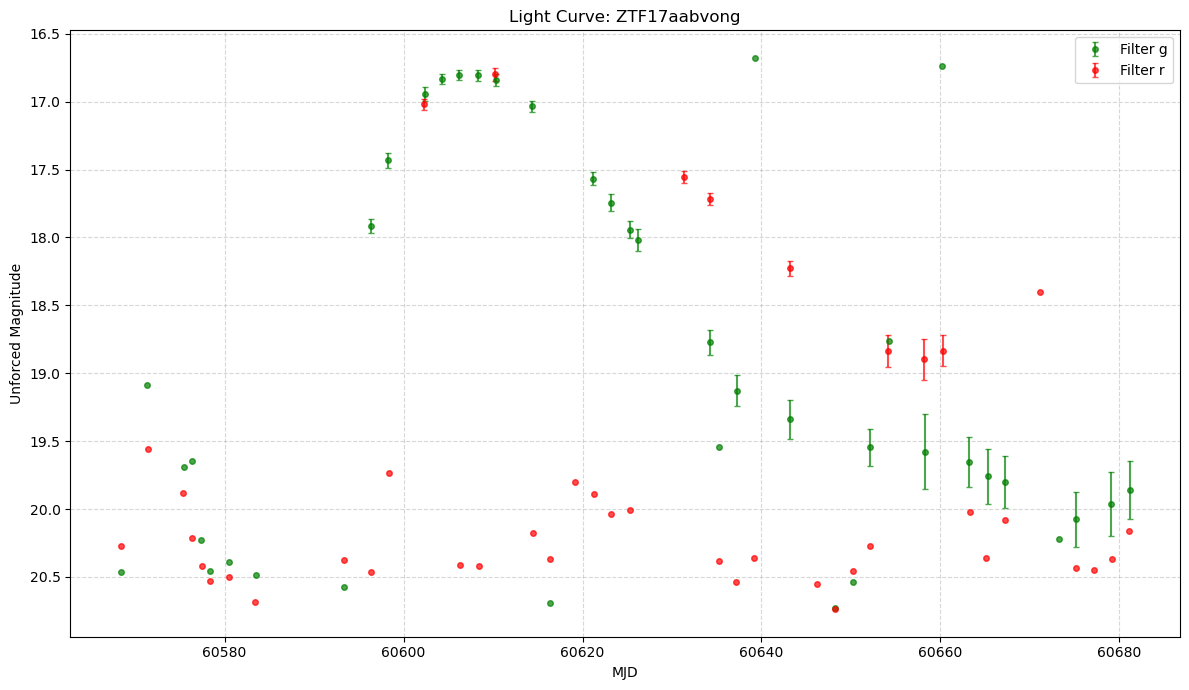

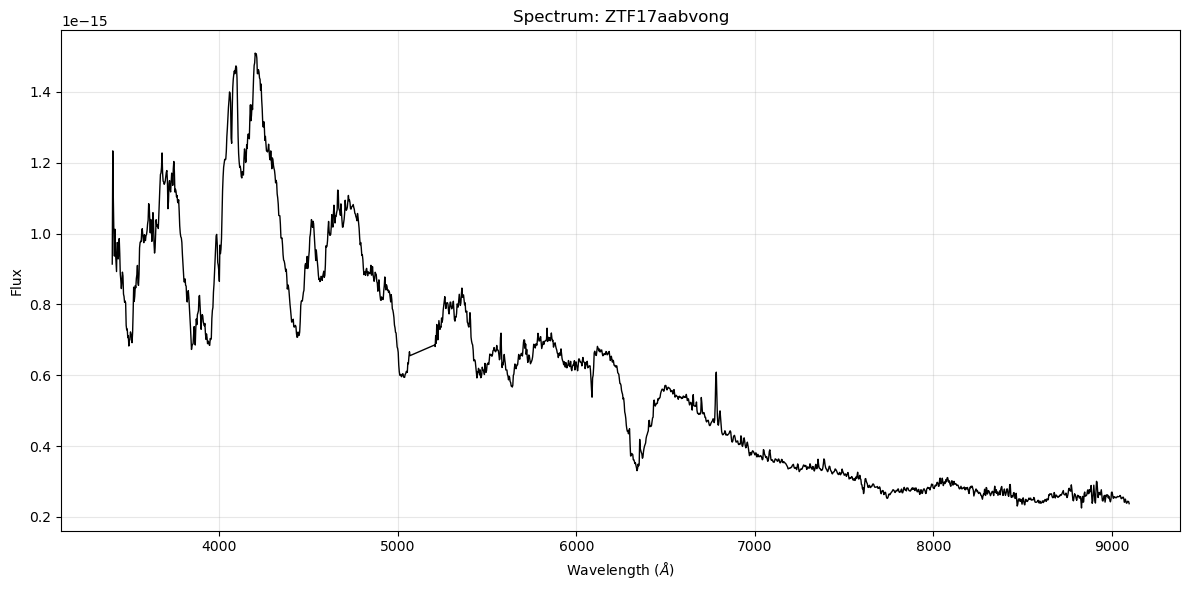

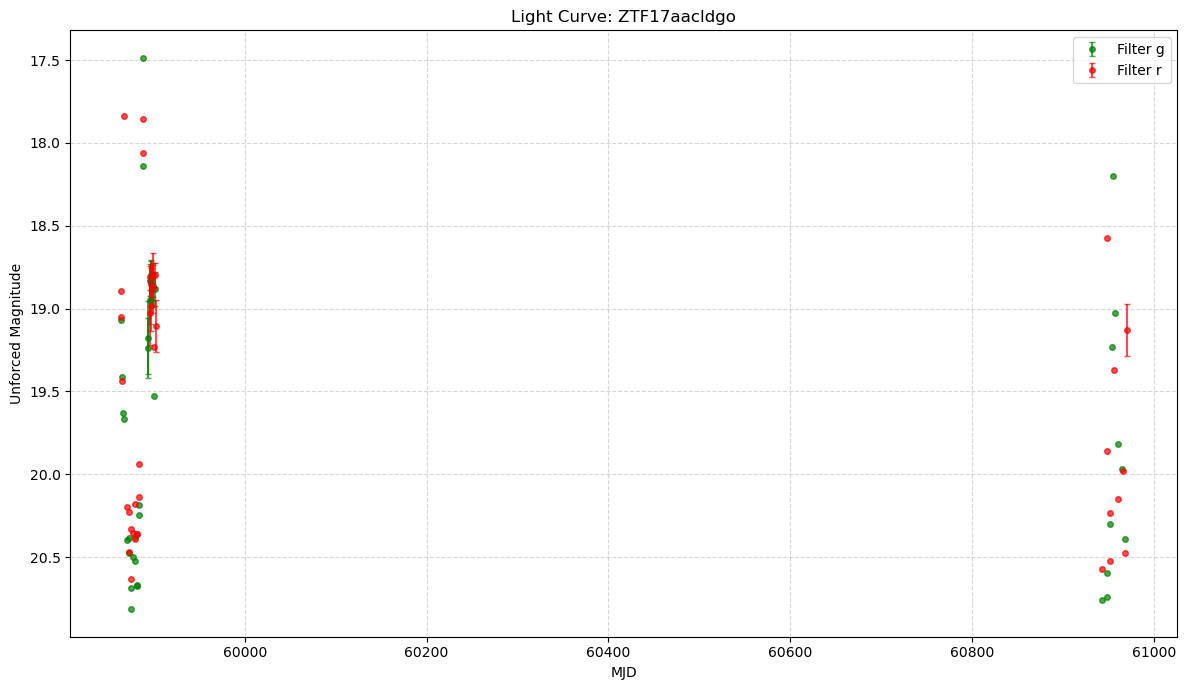

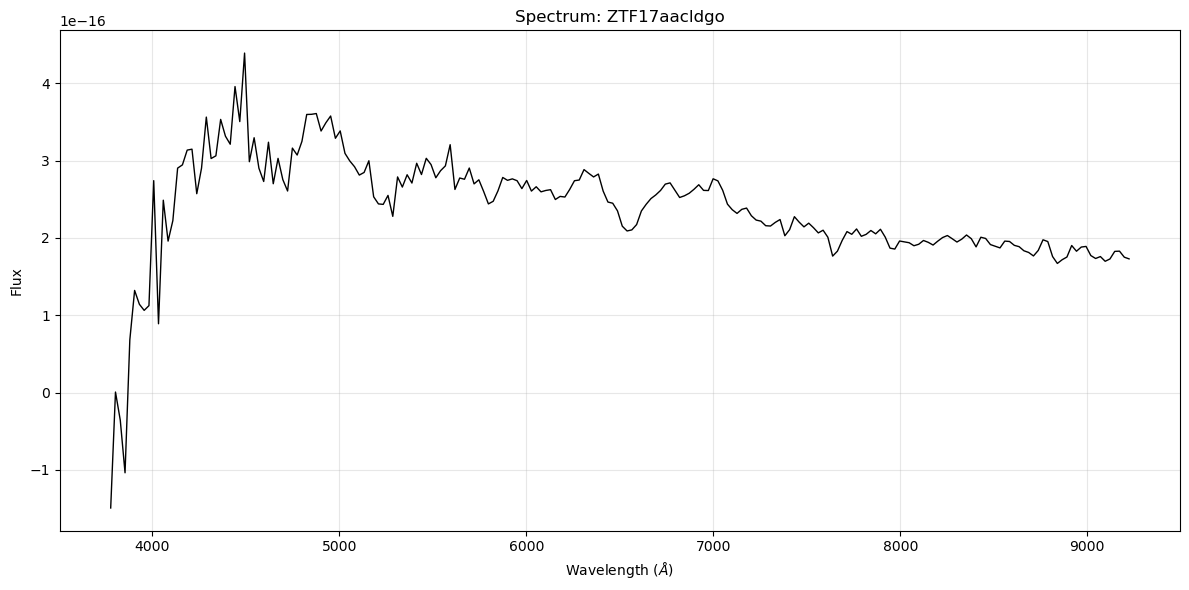

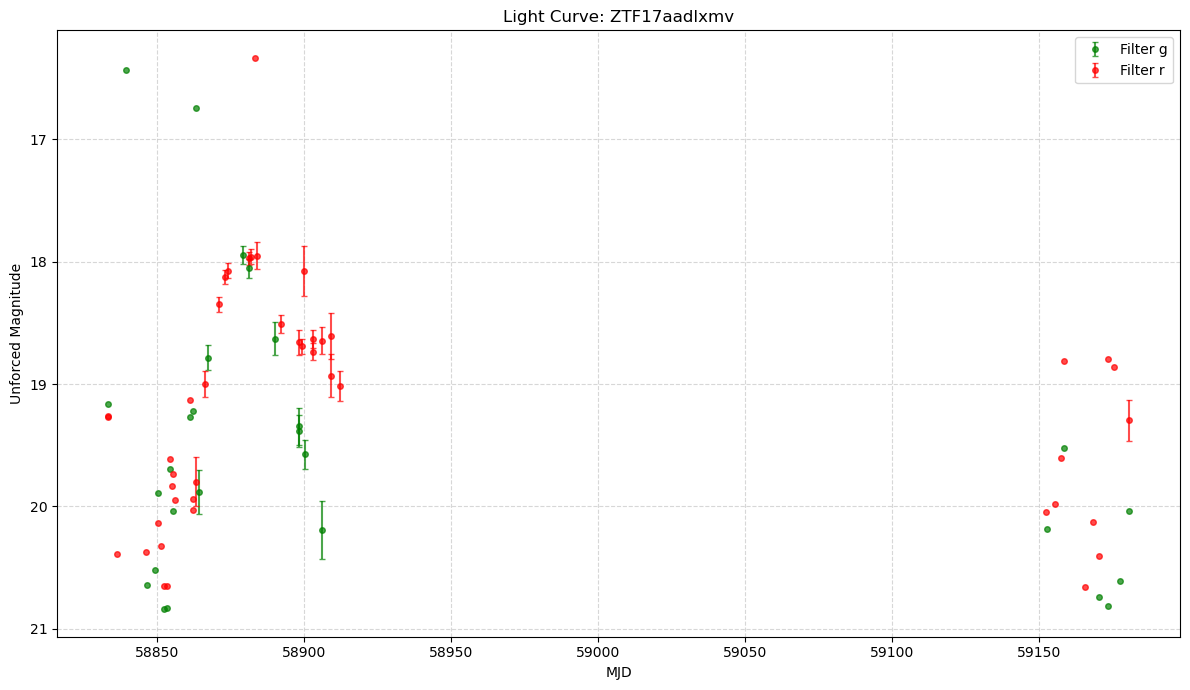

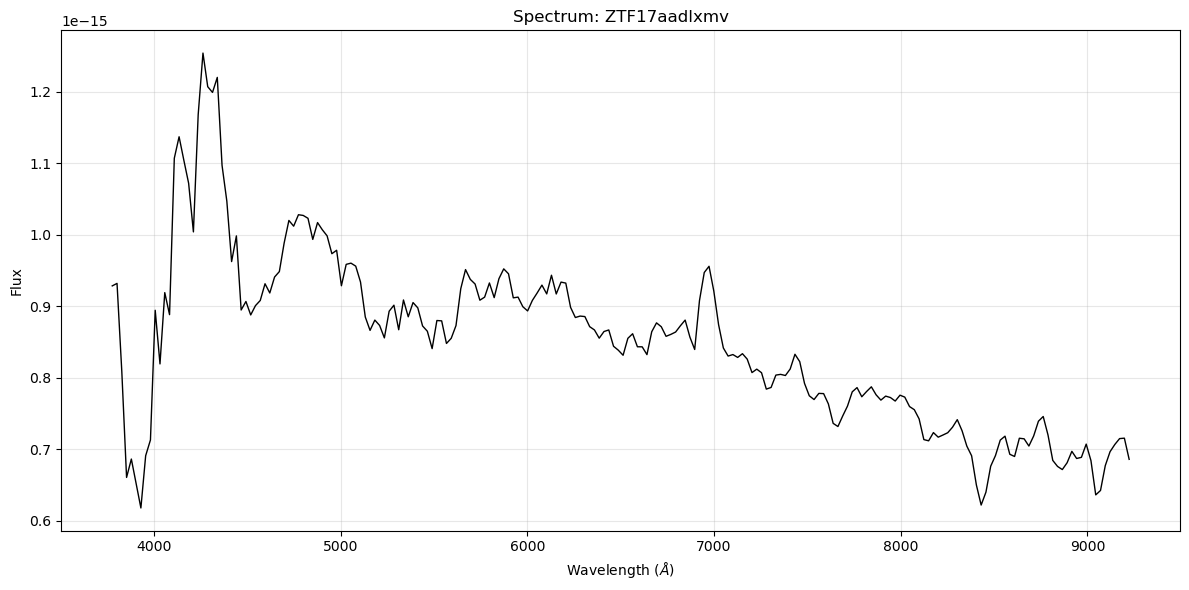

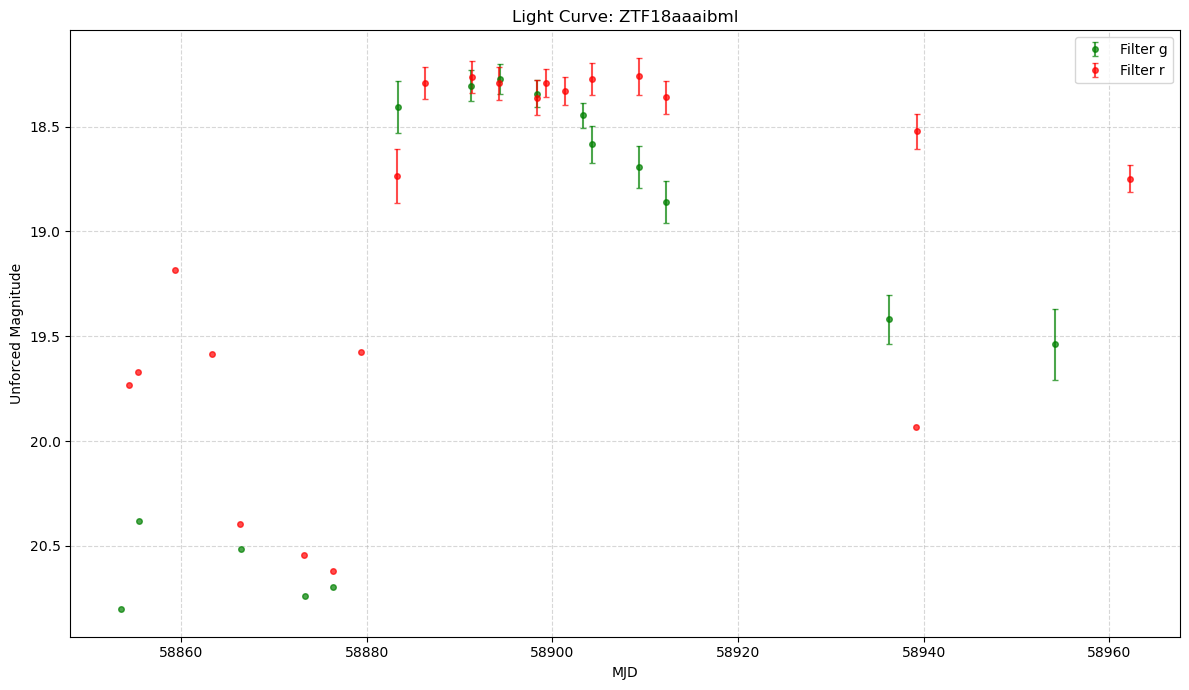

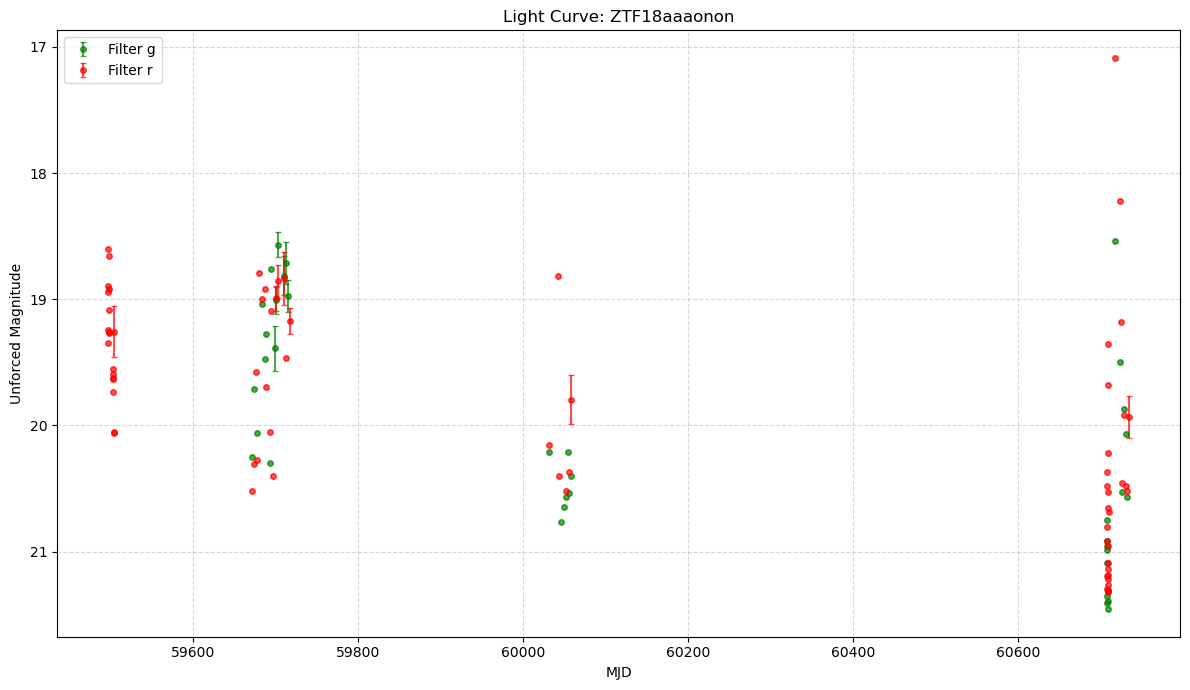

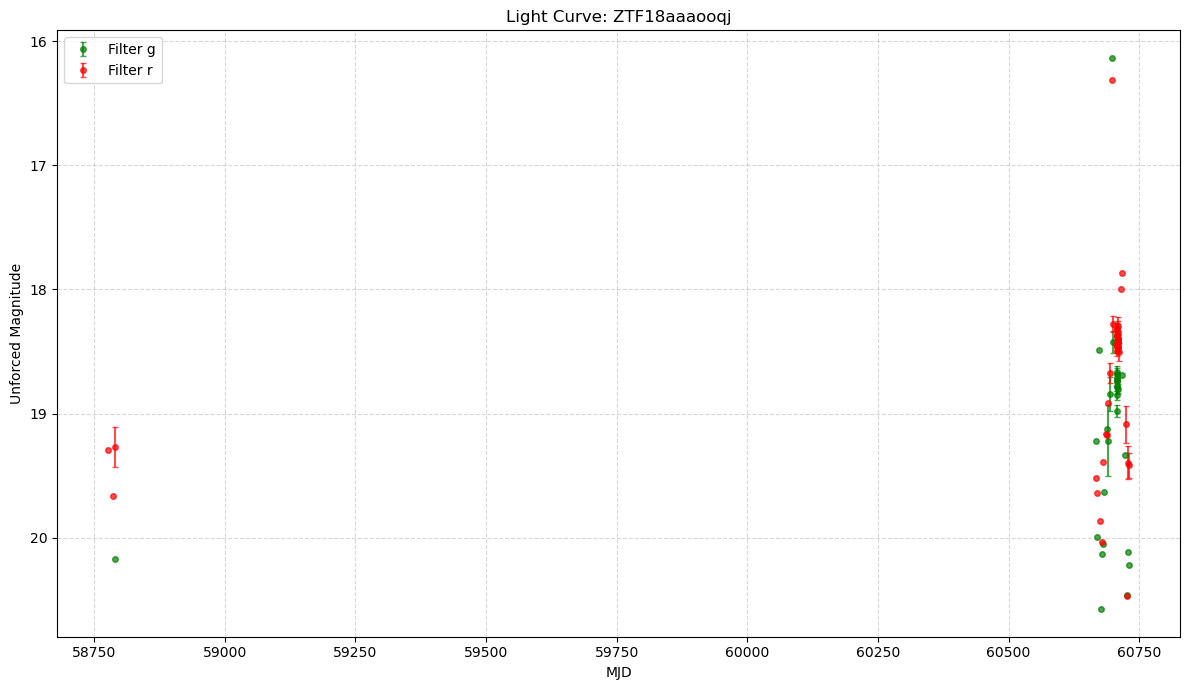

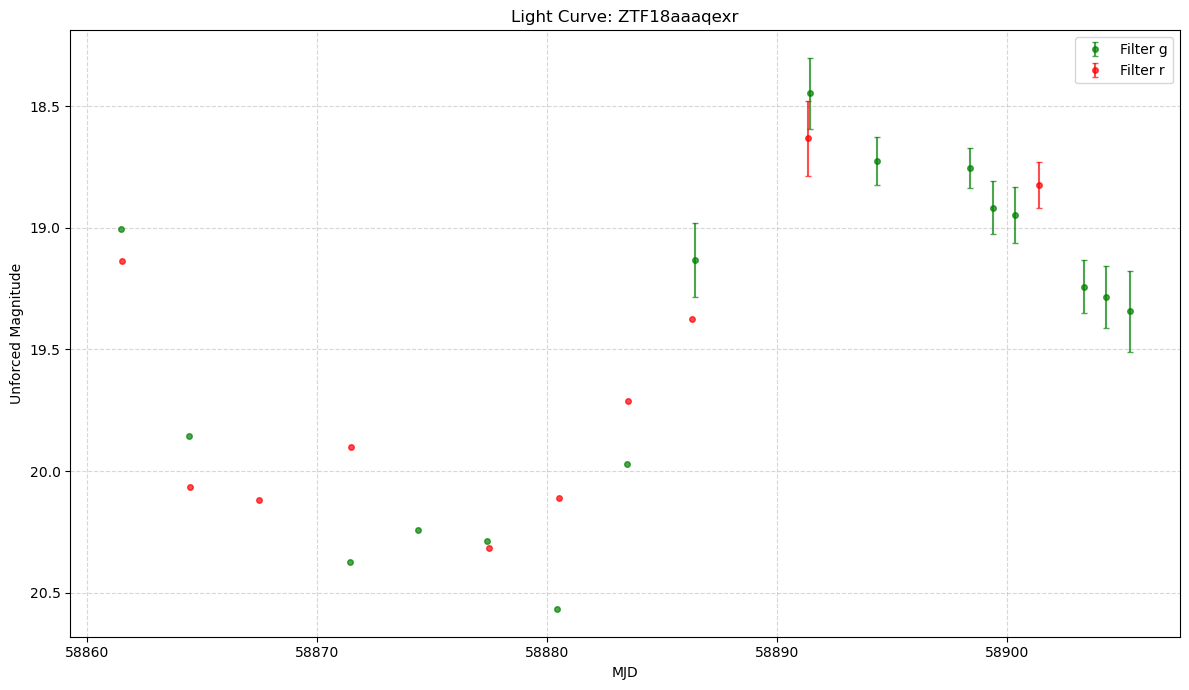

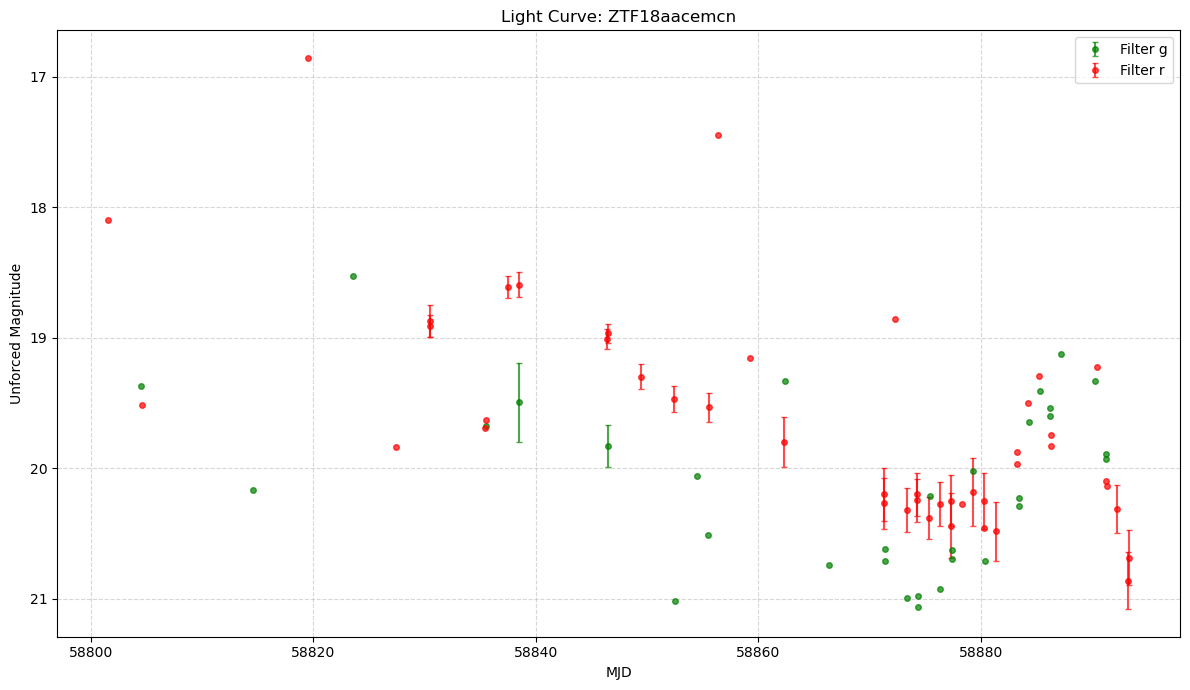

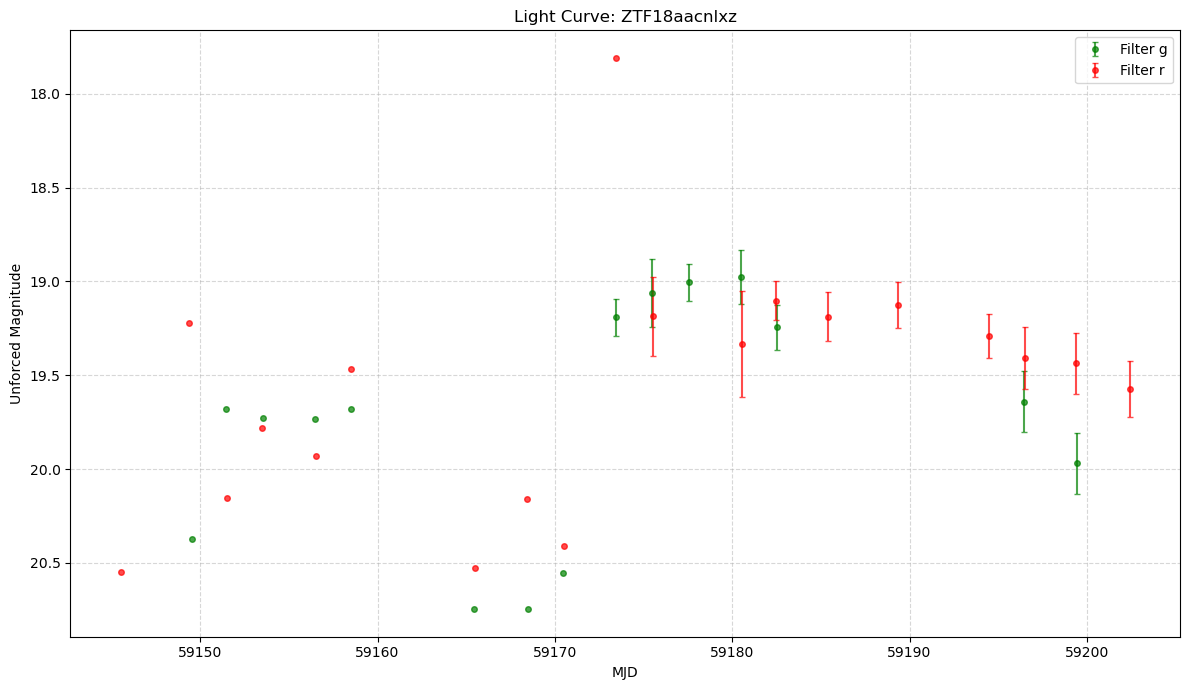

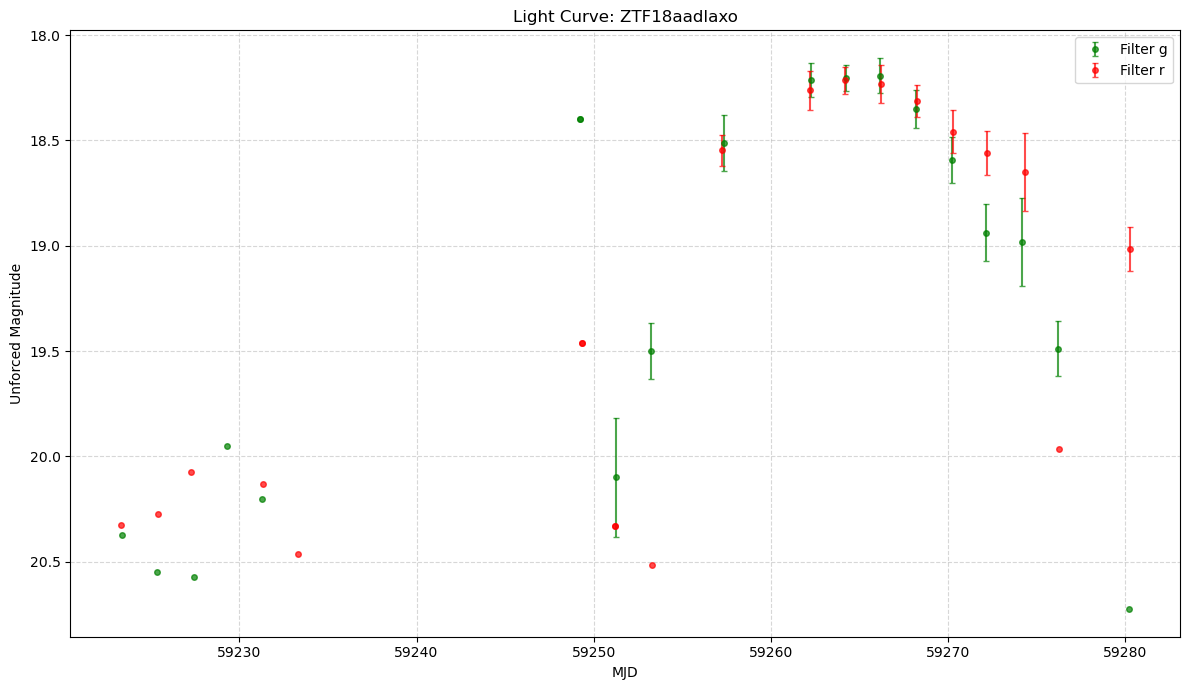

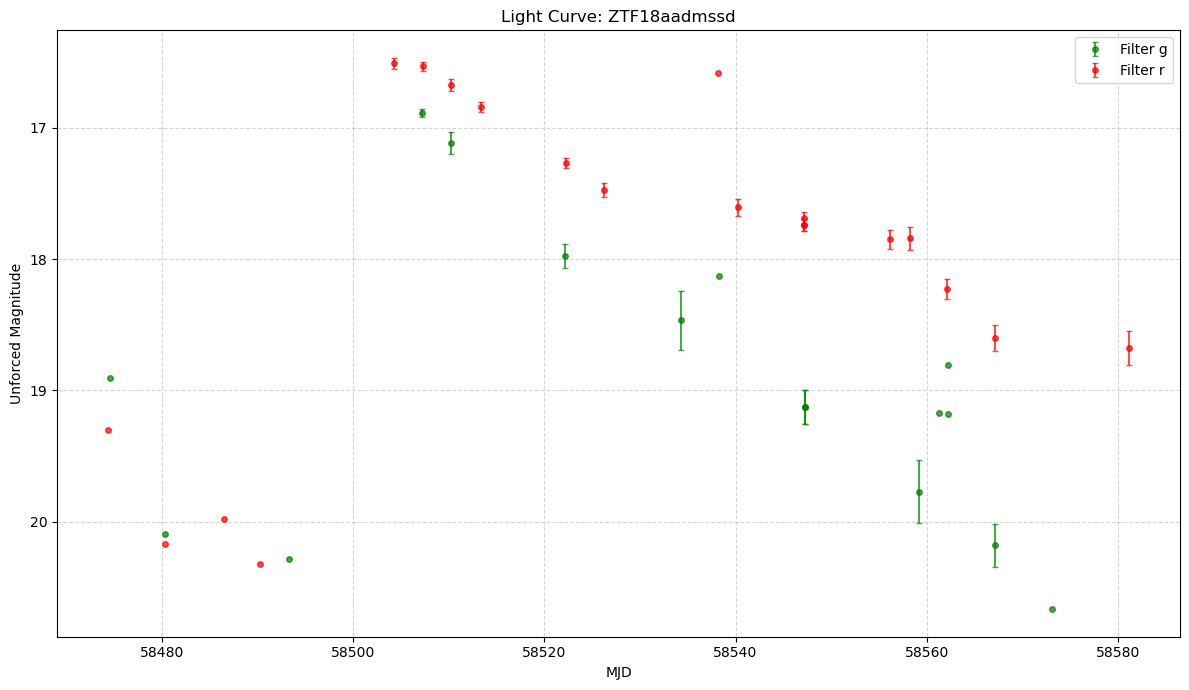

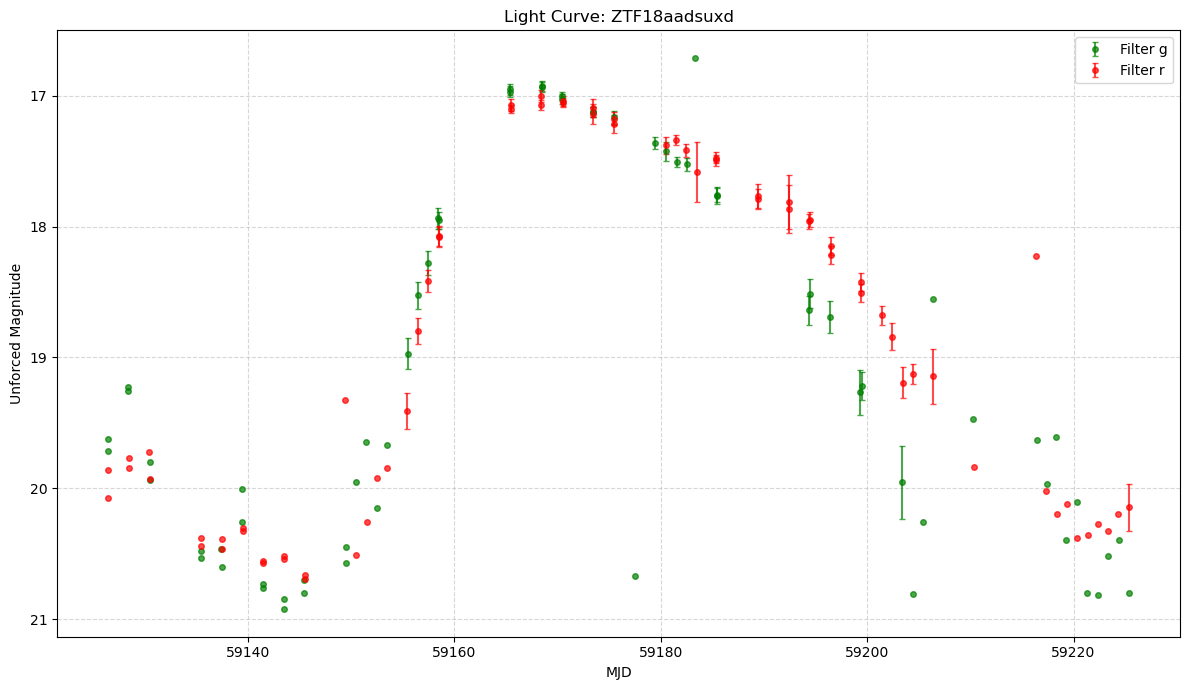

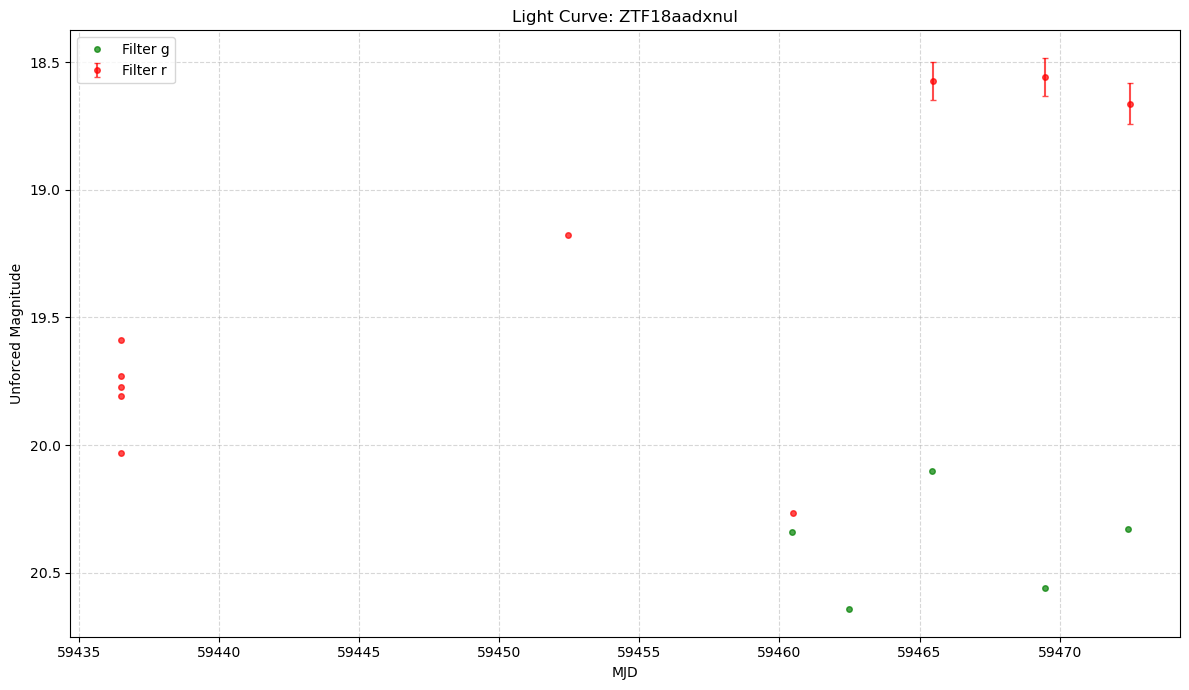

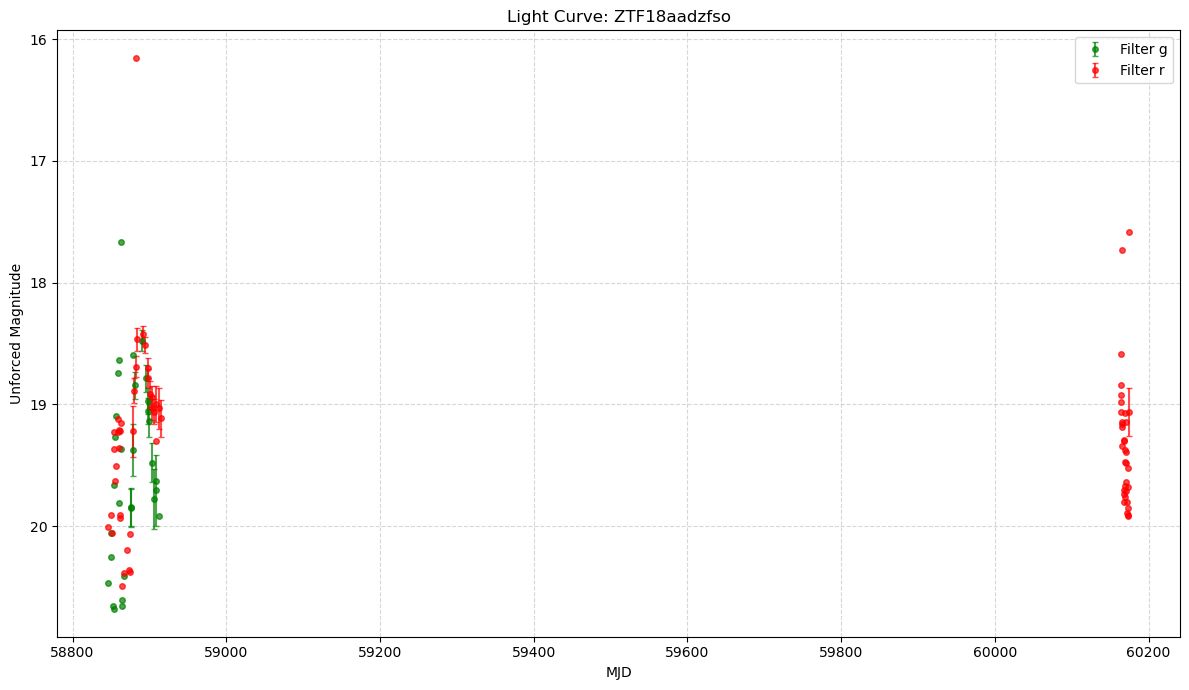

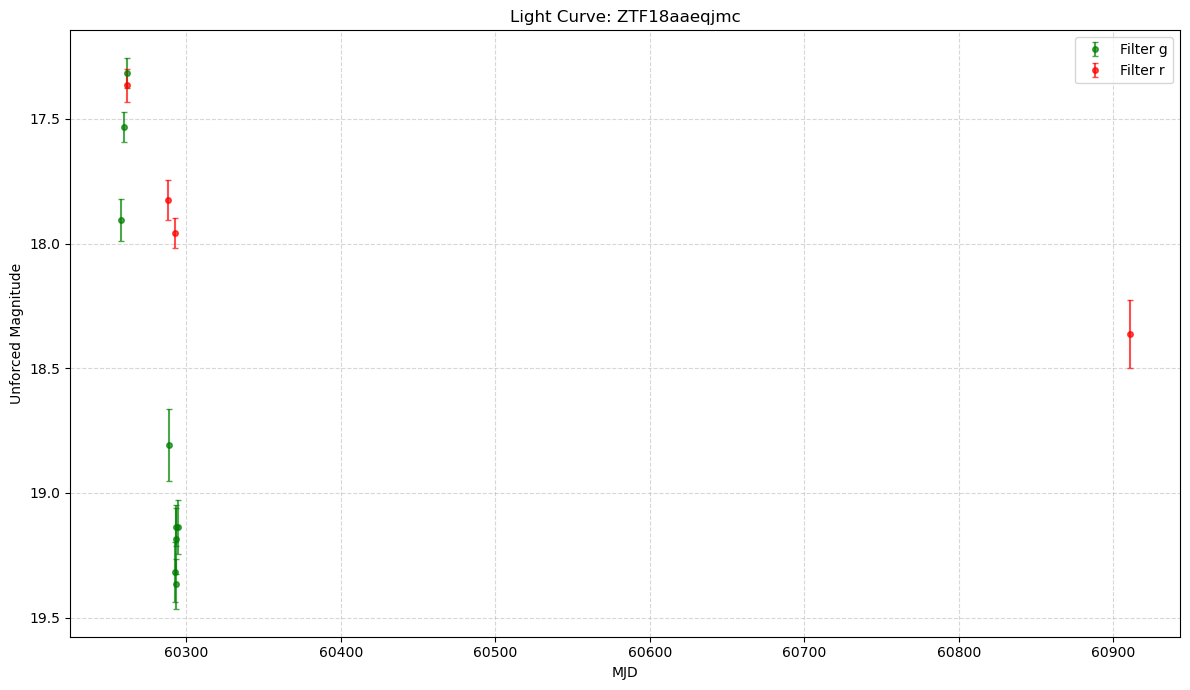

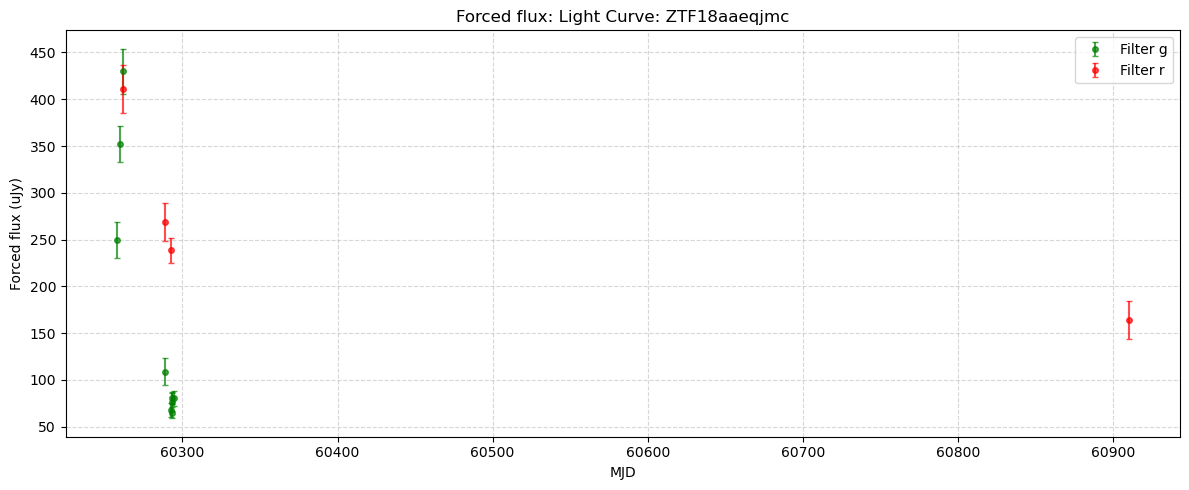

In [ ]:
# Plot light curves and spectra 
tracker_path = project_root / "data" / run_name / "tracker.csv"

if not objects_to_process.empty and tracker_path.exists():
    tracker_df = pd.read_csv(tracker_path)
    total = len(objects_to_process)

    for idx, (_, obj_row) in enumerate(objects_to_process.iterrows(), 1):
        ztf_id = obj_row['ZTFID']
        row = tracker_df[tracker_df['ztf_id'] == ztf_id]
        lasair_path = (project_root / row.iloc[0]['lasair_path']) if not row.empty and pd.notna(row.iloc[0].get('lasair_path')) and str(row.iloc[0]['lasair_path']).strip() else None
        tns_path = (project_root / row.iloc[0]['tns_path']) if not row.empty and pd.notna(row.iloc[0].get('tns_path')) and str(row.iloc[0]['tns_path']).strip() else None
        if lasair_path is not None and not lasair_path.exists():
            lasair_path = None
        if tns_path is not None and not tns_path.exists():
            tns_path = None
        if lasair_path is None and tns_path is None:
            print(f"[{idx}/{total}] {ztf_id}: Skipping (no data in tracker)")
            continue
        
        try:
            run_dir = project_root / "runs" / run_name / ztf_id
            # process the light curve
            try:
                clean_lasair_lightcurve(lasair_csv_path)
                update_tracker(
                            ztf_id,
                            lasair_status="cleaned",
                        )
            except Exception as e:
                print(f"Error processing data: {e}")    
            # plot light curve and spectrum
            lc_path = plot_light_curve_from_lasair(ztf_id, lasair_path, run_dir) if lasair_path else None
            # spec_path = plot_spectrum_from_tns(ztf_id, tns_path, run_dir) if tns_path else None
            
            if lc_path:
                print(f"[{idx}/{total}] {ztf_id}: Light curve → {lc_path}")
            # if spec_path:
            #     print(f"[{idx}/{total}] {ztf_id}: Spectrum → {spec_path}")
        except Exception as e:
            print(f"[{idx}/{total}] {ztf_id}: Plotting failed - {str(e)}")
    print(f"\nPlotting complete for {total} object(s)")
else:
    if objects_to_process.empty:
        print("\nNo objects to plot.")
    else:
        print("\nNo tracker found.")

In [67]:
# SNcosmo fitting
filter_map = {"g": "ztfg", "r": "ztfr"}

tracker_path = project_root / "data" / run_name / "tracker.csv"
if objects_to_process.empty or not tracker_path.exists():
    print("No objects to process.")
else:
    tracker_df = pd.read_csv(tracker_path)

    print("Beginning sncosmo processing...")

    for _, obj_row in objects_to_process.iterrows():
        ztf_id = obj_row["ZTFID"]
        z = float(obj_row["redshift"])

        # peak time in ztf.csv is JD-2458000 -> convert to MJD
        peak_time = float(obj_row["peakt"])            # JD-2458000
        peak_mjd = peak_time + 57999.5                 # MJD_peak = time + 57999.5

        row = tracker_df[tracker_df["ztf_id"] == ztf_id]
        if row.empty:
            print(f"Skipping {ztf_id}: not in tracker")
            continue

        lasair_path_str = row.iloc[0].get("lasair_path")
        if not (pd.notna(lasair_path_str) and str(lasair_path_str).strip()):
            print(f"Skipping {ztf_id}: no Lasair path")
            continue

        lasair_path = project_root / str(lasair_path_str).strip()
        if not lasair_path.exists():
            print(f"Skipping {ztf_id}: file not found {lasair_path}")
            continue

        # Load lightcurve
        lc_df = load_lasair_lightcurve(lasair_path)
        lc_df["filter"] = lc_df["filter"].astype(str).str.strip().str.lower()

        # Keep only ±10 days around peak MJD
        lc_df = lc_df[(lc_df["MJD"] >= peak_mjd - 10) & (lc_df["MJD"] <= peak_mjd + 10)].copy()

        if len(lc_df) < 5:
            print(f"Skipping {ztf_id}: too few usable points in ±10d window ({len(lc_df)})")
            continue

        bands = [filter_map[f] for f in lc_df["filter"].values]

        data = Table({
            "time": lc_df["MJD"].values,
            "band": bands,
            "flux": lc_df["forced_ujy"].values,
            "fluxerr": lc_df["forced_ujy_error"].values,
            "zp": np.full(len(lc_df), 23.9),
            "zpsys": np.array(["ab"] * len(lc_df)),
        })

        model = sncosmo.Model(source="salt3")
        model.set(z=z)

        # Fit
        fit_params = ["t0", "x0", "x1", "c"]
        bounds = {"x1": (-3, 3), "c": (-0.3, 0.3)}

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            result, fitted_model = sncosmo.fit_lc(data, model, fit_params, bounds=bounds)

        print(f"\n--- {ztf_id} ---")
        print("peak_mjd:", peak_mjd)
        print("ndof:", result.ndof)
        print("chisq:", result.chisq)
        print("best-fit:", dict(zip(result.param_names, result.parameters)))

        sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)
        plt.gcf().suptitle(ztf_id)
        plt.show()


Beginning sncosmo processing...


DataQualityError: No data points with S/N > 5.0. Initial guessing failed.